# K-Means

For this problem, you will be implementing the K-Means algorithm. This is an unsupervised learning algorithm for clustering problems. That is, its objective is to produce a partitioning over a dataset without (explicit) external supervision of which group each datapoint should belong to.

Your initial implementation should be a standard K-means algorithm with Euclidean distance metric. A concise description can be found in [Andrew NG's lecture notes on K-Means](http://cs229.stanford.edu/notes2020spring/cs229-notes7a.pdf). The first part of Chapter 9 of _Pattern Recognition and Machine Learning_ by Christopher M. Bishop also gives a good overview of the algorithm, as well as its connection to the Expection Maximization (EM) algorithm.

We have provided some skeleton code for the classifier, along with a couple of utility functions in the [k_means.py](./k_means.py) module. Please fill out the functions marked with `TODO` and feel free to add extra constructor arguments as you see fit (just make sure the default constructor solves the first dataset).

In [1]:
%load_ext autoreload

We begin by loading necessary packages. Below follows a short description of the imported modules:

- `numpy` is the defacto python package for numerical calculation. Most other numerical libraries (including pandas) is based on numpy.
- `pandas` is a widely used package for manipulating (mostly) tabular data
- `matplotlib` is the most used plotting library for python
- `seaborn` contains several convience functions for matplotlib and integrates very well with pandas
- `k_means` refers to the module in this folder that should be further implemented by you.

Note: The `%autoreload` statement is an [IPython magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) that automatically reloads the newest version of all imported modules within the cell. This means that you can edit the `k_means.py` file and just rerun this cell to get the updated version.

In [4]:
%autoreload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
import seaborn as sns 
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")
import k_means as km # <-- Your implementation
import math

sns.set_style('darkgrid')

## [1] First Dataset

The first dataset is a simple problem that is well suited for K-Means. It consists of 500 datapoints ($x_0, x_1 \in \mathbb{R}$) that should be partitioned into two clusters.

### [1.1] Load Data

We begin by loading data from a .csv file located in the same folder as this notebook.

In [5]:
data_1 = pd.read_csv('data_1.csv')
data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,500.0,0.487285,0.270455,0.009609,0.244733,0.403656,0.740552,0.987812
x1,500.0,0.500124,0.094661,0.177059,0.440589,0.500784,0.563798,0.814569


### [1.2] Visualize

Since the data is 2-dimensional, it lends itself nicely to visualization with a scatter plot. From this, it should be evident what a sensible clustering should look like.

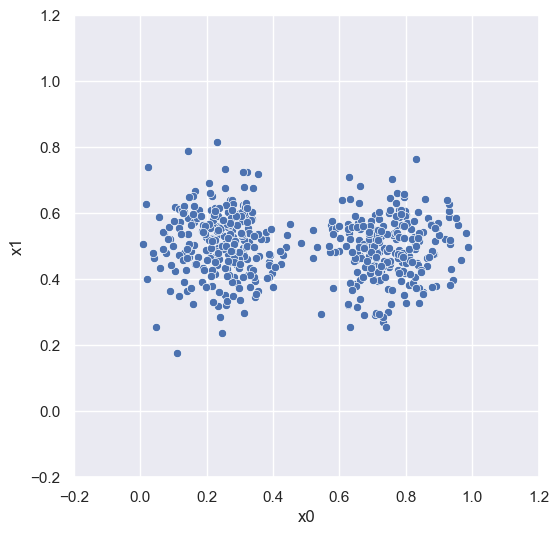

In [6]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='x0', y='x1', data=data_1)
plt.xlim(-0.2, 1.2); plt.ylim(-0.2, 1.2);

### [1.3] Fit and Evaluate

Next we fit and evaluate your K-Means clustering model over the dataset. It should work with the default constructor, but it is perfectly fine if you make the default constructor configure the algorithm for two centroids. 

We will quantitatively evaluate the solution according to _distortion_ and the _silhouette score_ (both assuming a euclidean distance metric).

- The distortion measure is equal to the sum of squared distances between each point and the centroid it is assigned to. It favors cohesive clusters, i.e. clusters where all points are close to their centroids, and is used as a minimization objective by K-Means.

- The [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering) measures both cluster cohesion and separation. I.e., it also accounts for to what degree each cluster is isolated from other clusters. It takes on values in the range (-1, 1) and is subject to maximization.
X1
Note that `.fit`, `.predict`, and `.get_centroids` will crash until you implement these two methods in [k_means.py](./k_means.py). The `.get_centroids` method is used fetch the cluster centroids which are visualized as stars in the figure.

Assuming a standard implementation of K-means, you should expect to get a sihouette score of ~0.67 and a distortion measure of ~8.8. You can also verify that everything is working as it should by inspecting the generated figure. A working algorithm should generate centroids such that all the points with $x_0 < 0.5$ (approximately) are assigned to one cluster and the remaining are assigned to the other.

Iterations: 5 

My output:
Silhouette Score: 0.672
Distortion: 8.837


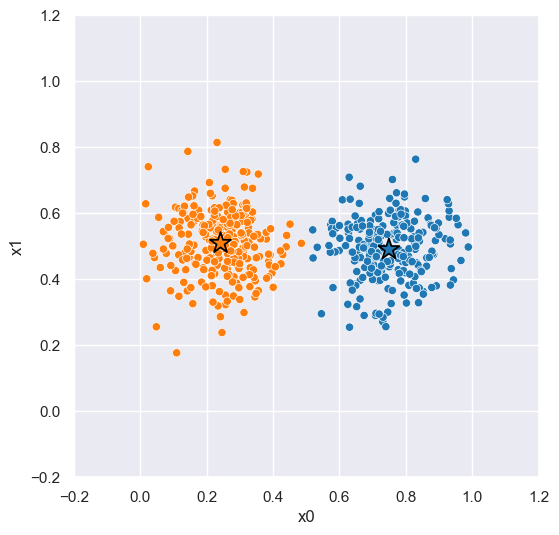

In [8]:
# Fit Model
X1 = data_1[['x0', 'x1']]
model_1 = km.KMeans(2) # <-- Should work with default constructor
z1, C1 = model_1.fit(X1)

# Compute Silhouette Score
print("My output:")
z1 = np.array(z1)
print(f'Silhouette Score: {km.euclidean_silhouette(X1, z1) :.3f}')
print(f'Distortion: {km.euclidean_distortion(X1, z1) :.3f}')

# Plot cluster assignments
C1 = np.array(C1)
K1 = len(C1)
_, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='x0', y='x1', hue=z1, hue_order=range(K1), palette='tab10', data=X1, ax=ax);
sns.scatterplot(x=C1[:,0], y=C1[:,1], hue=range(K1), palette='tab10', marker="*", s=250, edgecolor='black', ax=ax)
plt.xlim(-0.2, 1.2); plt.ylim(-0.2, 1.2)
ax.legend().remove();

## [2] Second Dataset

The second dataset is superficially similar to the first one. The goal is still to partition a two-dimensional dataset into mutually exlusive groups, but it is designed to be a bit more challenging.

### [2.1] Load Data

This dataset can also be found in a .csv file in the same folder as this notebook.

In [9]:
data_2 = pd.read_csv('data_2.csv')
data_2["x0"] = data_2["x0"]/100
data_2["x1"] = data_2["x1"]/10
data_2.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,800.0,0.467885,0.284447,-0.039975,0.233582,0.455488,0.637536,1.109681
x1,800.0,0.517925,0.335063,-0.095129,0.171306,0.646318,0.778081,1.156256


### [2.2] Visualize Data

As can be seen, there are substantially more clusters in this dataset. We generated a total of 8 clusters that your algorithm should be able to identify. It is ok if you pass information about the number of clusters to your model during instantiation, but it should be able to initialize itself and identify a good clustering without any external information.

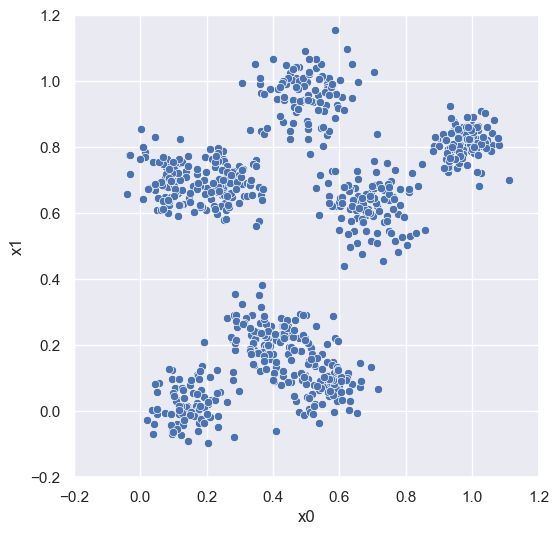

In [10]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='x0', y='x1', data=data_2)
plt.xlim(-0.2, 1.2); plt.ylim(-0.2, 1.2);

### [2.3] Fit and Evaluate

Again, we fit the model to the data, measure distortion and silhouette score, and visualize the resulting clusters. You may experience that the algorithm you implemented for the first dataset fails to find all the clusters, at least consistently. 

Feel free to add extra functionality to the algorithm and/or the data preprocessing pipeline that improve performance. It might be useful to run the algorithm for one iteration at the time and plot the resulting clustering to get a better idea of what is going on. 

As a debugging reference; it should be possible to create an implementation that finds all the 8 clusters (at least) 9/10 times with randomized initialization. 

Iterations: 11 

My output:
Distortion: 5.609
Silhouette Score: 0.589


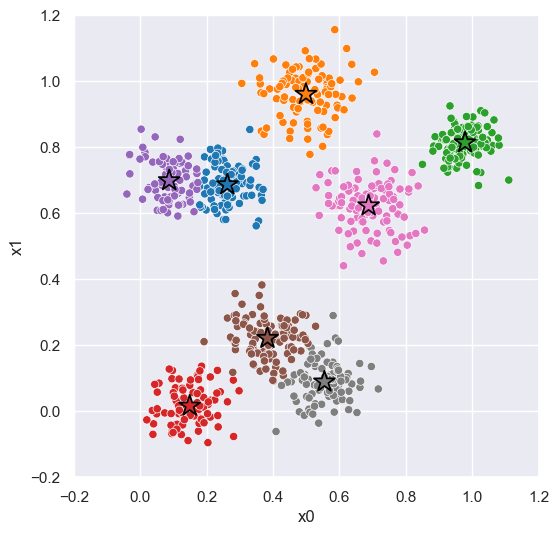

In [11]:
# Fit Model 
X2 = data_2[['x0', 'x1']]
model_2 = km.KMeans(8)  # <-- Feel free to add hyperparameters 
z2, C2 = model_2.fit(X2)

# Compute Silhouette Score 
print("My output:")
z2 = np.array(z2)
print(f'Distortion: {km.euclidean_distortion(X2[["x0", "x1"]], z2) :.3f}')
print(f'Silhouette Score: {km.euclidean_silhouette(X2[["x0", "x1"]], z2) :.3f}')

# Plot cluster assignments
C2 = np.array(C2)
K2 = len(C2)
_, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='x0', y='x1', hue=z2, hue_order=range(K2), palette='tab10', data=X2[["x0", "x1"]], ax=ax);
sns.scatterplot(x=C2[:,0], y=C2[:,1], hue=range(K2), palette='tab10', marker="*", s=250, edgecolor='black', ax=ax)
plt.xlim(-0.2, 1.2); plt.ylim(-0.2, 1.2)
ax.legend().remove();

## [3] Further Steps (optional)

If you're done with the assignment but want to some more challenges; consider the following:

- Modify your clustering algorithm so that the user no longer has to enter the number of clusters manually.
- K-means makes hard cluster assignments. Try implementing the [EM-algorithm](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm) to fit a gaussian mixture model to the data above.
- Implement a clustering algorithm that solves the dataset below. 

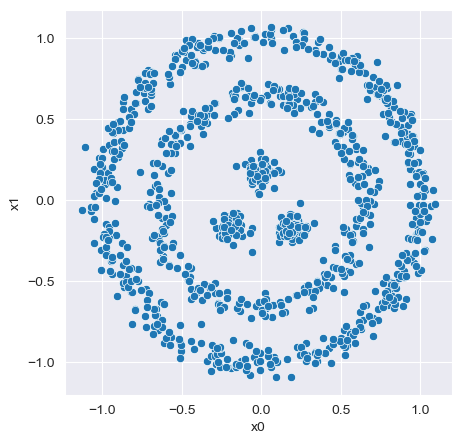

In [23]:
data_bonus = pd.read_csv('data_bonus.csv')
plt.figure(figsize=(5, 5))
sns.scatterplot(x='x0', y='x1', data=data_bonus);